# Lesson 2: Planet

### Google Colab Setup

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com.
Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'.
This will trigger the download of kaggle.json, a file containing your API credentials.

In [ ]:
from google.colab import files
uploaded = files.upload() # Choose your local kaggle.json file

# move the file into place and update it's permissions
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# install kaggle command line tool and use it to download the planet datset files we need
!mkdir -p ~/data/planet
!pip install kaggle
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p ~/data/planet
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv.zip -p ~/data/planet

# decompress the data
!apt-get install p7zip-full

!7za x ~/data/planet/train-jpg.tar.7z -o$HOME/data/planet
!tar -xf ~/data/planet/train-jpg.tar -C ~/data/planet
!rm -f   ~/data/planet/train-jpg.*

!unzip -d ~/data/planet ~/data/planet/train_v2.csv.zip
!rm -f ~/data/planet/train_v2.csv.zip

In [ ]:
!pip install sconce==0.9.4
!pip install --no-cache-dir -I Pillow==5.0.0

### Construct the training and test datasets

In [1]:
from sconce.datasets.csv_image_folder import CsvImageFolder
from torch.utils import data
from torchvision import transforms
import numpy as np
import torch

image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

base_dir = 'data/planet/'
full_dataset = CsvImageFolder(root=base_dir+'train-jpg',
                              csv_path=base_dir+'train_v2.csv',
                              transform=transform)

# split the dataset into a training subset and test subset
np.random.seed(0)
num_samples = len(full_dataset)
indices = np.arange(0, num_samples)
np.random.shuffle(indices)
training_dataset = data.dataset.Subset(full_dataset, indices=indices[:int(num_samples*0.8)])
test_dataset = data.dataset.Subset(full_dataset, indices=indices[int(num_samples*0.8):])

In [2]:
from sconce.data_generators import ImageDataGenerator

loader_kwargs = {
    'batch_size': 256,
    'shuffle': True,
    'num_workers': 0
}

training_data_generator = ImageDataGenerator.from_dataset(training_dataset, **loader_kwargs)
test_data_generator = ImageDataGenerator.from_dataset(test_dataset, **loader_kwargs)

## Define model

In [ ]:
!pip install scikit-learn==0.19.1

In [3]:
from sklearn.metrics import fbeta_score
import warnings
from torch import nn
import torchvision

class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.criterion = nn.MultiLabelSoftMarginLoss()
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        return {'outputs': x}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': self.criterion(input=outputs, target=targets)}

    def calculate_metrics(self, targets, outputs, **kwargs):
        targets = targets.cpu().data.numpy()
        outputs = outputs.cpu().data.numpy()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return {'fbeta': fbeta_score(y_true=targets,
                               y_pred=(outputs>0.2),
                               beta=2,
                               average='samples')}
    
def create_model():
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = torchvision.models.resnet18(pretrained=True)
    
    # Freeze all layers, so they don't get updated during training.
    for param in base_model.parameters():
        param.requires_grad = False
        
    # Replace last fully-connected layer with one that outputs only two categories (cat / dog).
    # This is now the only layer that isn't yet trained.
    num_classes = training_dataset.dataset.num_classes
    base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=num_classes)
    return MyModel(base_model)

In [4]:
model = create_model()

if torch.cuda.is_available():
    model.cuda()
    training_data_generator.cuda()
    test_data_generator.cuda()

In [5]:
from torch import optim
from sconce.trainers import ClassifierTrainer

optimizer = optim.Adam(model.base_model.fc.parameters(),
        weight_decay=1e-4)

trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

50/64 [======================>.......] - ETA: 12s - loss: 0.5105

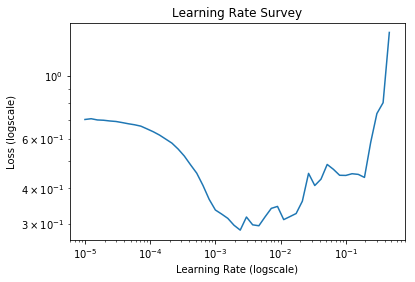

In [6]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [7]:
from sconce import rate_controllers

rc = rate_controllers.TriangleRateController(
    max_learning_rate=2e-3,
    min_learning_rate=2e-4)
trainer.train(num_epochs=1, rate_controller=rc);

127/127 [==============================] - 143s 1s/step - loss: 0.2302 - val_loss: 0.2406


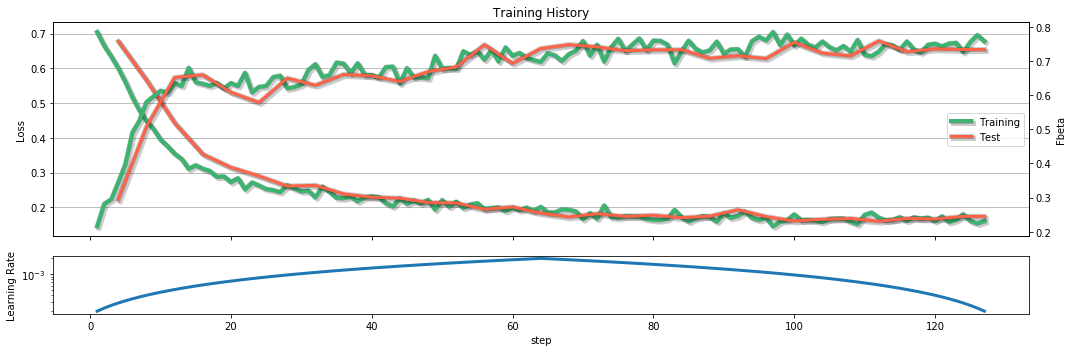

In [8]:
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'fbeta']);

## Differential Learning Rates

In [9]:
model = create_model()
model.cuda()

# Print a model summary
model.base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
base_model = model.base_model

params_list = []

# ==== layer 4 ====
params = []
for param in base_model.layer4.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})

# ==== fc layer ====
params = []
for param in base_model.fc.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})
    
optimizer = optim.Adam(params_list)

In [11]:
trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

56/64 [=========================>....] - ETA: 8s - loss: 0.3915

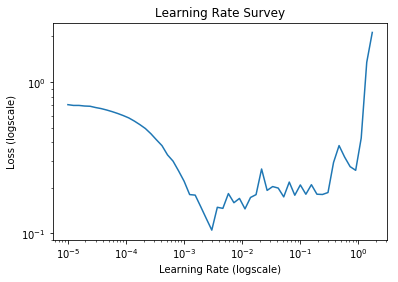

In [12]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=20)
survey_monitor.dataframe_monitor.plot_learning_rate_survey();

In [13]:
base_lr = 2e-3

layer_factor = 0.1
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_layer_4 = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

layer_factor = 1.0
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_fc_layer = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

rc = rate_controllers.base.CompositeRateController([rc_layer_4, rc_fc_layer])

In [14]:
trainer.train(num_epochs=1, rate_controller=rc)

127/127 [==============================] - 154s 1s/step - loss: 0.1592 - val_loss: 0.1799


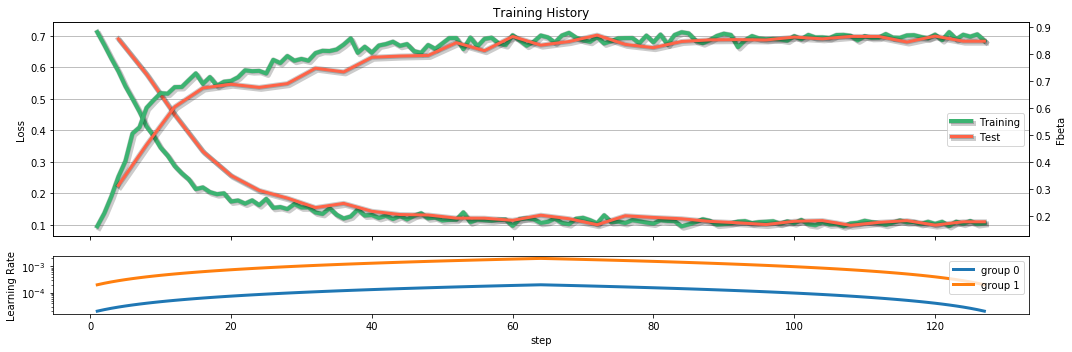

In [15]:
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'fbeta']);

In [16]:
monitor = trainer.test()

127/127 [==============================] - 113s 891ms/step - loss: 0.1033


In [17]:
monitor.dataframe_monitor.df.test_fbeta.mean()

0.8648302915819677

## More Differential Learning Rates

Since imagnet isn't very much like these aerial images, lets try fine-tuning the resnet layers 3 and 4.  Also, lets try training them more aggressively (higher learning rate).

In [18]:
model = create_model()
model.cuda()

base_model = model.base_model

params_list = []

# ==== layer 3 ====
params = []
for param in base_model.layer3.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})

# ==== layer 4 ====
params = []
for param in base_model.layer4.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})

# ==== fc layer ====
params = []
for param in base_model.fc.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})
    
optimizer = optim.Adam(params_list)

In [19]:
trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

61/64 [===========================>..] - ETA: 3s - loss: 0.5002

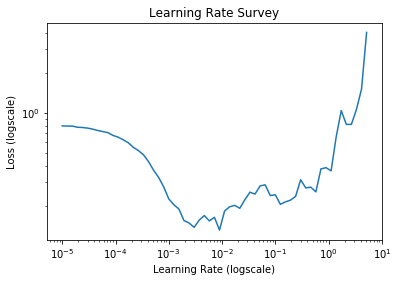

In [20]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=20)
survey_monitor.dataframe_monitor.plot_learning_rate_survey();

In [21]:
base_lr = 2e-3

layer_factor = 0.5
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_layer_3 = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

layer_factor = 1.0
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_layer_4 = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

layer_factor = 1.0
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_fc_layer = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

rc = rate_controllers.base.CompositeRateController([rc_layer_3, rc_layer_4, rc_fc_layer])

127/127 [==============================] - 163s 1s/step - loss: 0.1444 - val_loss: 0.1760


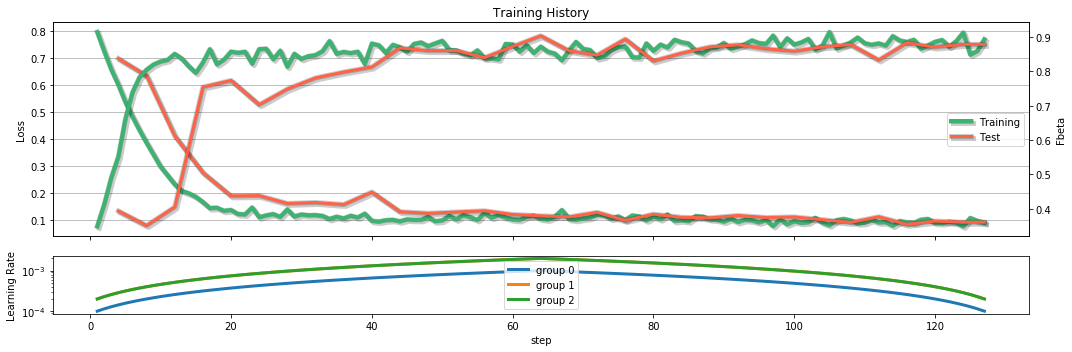

In [22]:
trainer.train(num_epochs=1, rate_controller=rc)
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'fbeta']);

In [23]:
monitor = trainer.test()
fbeta = monitor.dataframe_monitor.df.test_fbeta.mean()
print(f"Average fbeta score for test dataset: {fbeta}")

127/127 [==============================] - 113s 892ms/step - loss: 0.0960
Average fbeta score for test dataset: 0.8745226451001189
